In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

from datetime import datetime as dt
import itertools
from tqdm import tqdm
from scipy.stats import norm, t
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler,MinMaxScaler
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score,log_loss
# import lightgbm as lgb
import gc

from sklearn.model_selection import StratifiedKFold,KFold
from sklearn import metrics
import xgboost as xgb


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
train_ori = pd.read_csv('/kaggle/input/airquoi/train.csv',parse_dates=['date'])
test_ori = pd.read_csv('/kaggle/input/airquoi/test.csv',parse_dates=['date'])
ss =pd.read_csv('/kaggle/input/airquoi/SampleSubmission.csv')

In [5]:
# a = train.site_latitude.unique()
def get_prev(df,shifts = 1,col = 'pm2_5'):
    df['shifted_'+str(shifts)] = df.shift(shifts)[col].values
    return df
def target_encode(df_train,df_test,target,groupss):
    groupss_target_mean = df_train.groupby(groupss)[target].mean()
    groupss_target_max = df_train.groupby(groupss)[target].max()
    groupss_target_min = df_train.groupby(groupss)[target].min()
    groupss_target_std = df_train.groupby(groupss)[target].std()
    groupss_target_median = df_train.groupby(groupss)[target].apply(lambda x : np.median(x))
    groupss_target_q95 = df_train.groupby(groupss)[target].apply(lambda x : np.quantile(x,0.95))
    groupss_target_q05 = df_train.groupby(groupss)[target].apply(lambda x : np.quantile(x,0.05))
    groupss_target_skew = df_train.groupby(groupss)[target].skew()
    groupss_target_kurt = df_train.groupby(groupss)[target].apply(lambda x : x.kurtosis())
    # groupss_target_mean = df_train.groupby(groupss)[target].mean()
    df_test[groupss+target+'enc'] = df_test[groupss].map(groupss_target_mean)
    df_test[groupss+target+'enc'].fillna((df_test[groupss+target+'enc'].mean()), inplace=True)
    df_test[groupss+target+'enc1'] = df_test[groupss].map(groupss_target_max)
    df_test[groupss+target+'enc1'].fillna((df_test[groupss+target+'enc1'].mean()), inplace=True)
    df_test[groupss+target+'enc2'] = df_test[groupss].map(groupss_target_min)
    df_test[groupss+target+'enc2'].fillna((df_test[groupss+target+'enc2'].mean()), inplace=True)
    df_test[groupss+target+'enc3'] = df_test[groupss].map(groupss_target_std)
    df_test[groupss+target+'enc3'].fillna((df_test[groupss+target+'enc3'].mean()), inplace=True)
    df_test[groupss+target+'enc4'] = df_test[groupss].map(groupss_target_median)
    df_test[groupss+target+'enc4'].fillna((df_test[groupss+target+'enc4'].mean()), inplace=True)
    df_test[groupss+target+'enc5'] = df_test[groupss].map(groupss_target_q95)
    df_test[groupss+target+'enc5'].fillna((df_test[groupss+target+'enc5'].mean()), inplace=True)
    df_test[groupss+target+'enc6'] = df_test[groupss].map(groupss_target_q05)
    df_test[groupss+target+'enc6'].fillna((df_test[groupss+target+'enc6'].mean()), inplace=True)
    df_test[groupss+target+'enc7'] = df_test[groupss].map(groupss_target_skew)
    df_test[groupss+target+'enc7'].fillna((df_test[groupss+target+'enc7'].mean()), inplace=True)
    df_test[groupss+target+'enc8'] = df_test[groupss].map(groupss_target_kurt)
    df_test[groupss+target+'enc8'].fillna((df_test[groupss+target+'enc8'].mean()), inplace=True)
    tmp =np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : x.skew())
        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc7'] = tmp
    tmp =np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : x.kurtosis())

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc8'] = tmp
    
    tmp =np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : np.quantile(x,0.05))

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc6'] = tmp
    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991032)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : np.quantile(x,0.95))

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc5'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991035)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : np.median(x))

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc4'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].mean()

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991025)
    for idx_1, idx_2 in kf.split(df_train):
        target_max = df_train.iloc[idx_1].groupby(groupss)[target].max()

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_max)
    df_train[groupss+target+'enc1'] = tmp
    # from sklearn.model_selection import KFold/
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1990325)
    for idx_1, idx_2 in kf.split(df_train):
        target_min = df_train.iloc[idx_1].groupby(groupss)[target].min()

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_min)
    df_train[groupss+target+'enc2'] = tmp
    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_std = df_train.iloc[idx_1].groupby(groupss)[target].std()

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_std)
    df_train[groupss+target+'enc3'] = tmp
    df_train[groupss+target+'enc'].fillna((df_train[groupss+target+'enc'].mean()), inplace=True)
    df_train[groupss+target+'enc1'].fillna((df_train[groupss+target+'enc1'].mean()), inplace=True)
    df_train[groupss+target+'enc2'].fillna((df_train[groupss+target+'enc2'].mean()), inplace=True)
    df_train[groupss+target+'enc3'].fillna((df_train[groupss+target+'enc3'].mean()), inplace=True)
    df_train[groupss+target+'enc4'].fillna((df_train[groupss+target+'enc4'].mean()), inplace=True)
    df_train[groupss+target+'enc5'].fillna((df_train[groupss+target+'enc5'].mean()), inplace=True)
    df_train[groupss+target+'enc6'].fillna((df_train[groupss+target+'enc6'].mean()), inplace=True)
    return df_train, df_test


In [6]:
def preprocess(train,test):
    le = LabelEncoder()
    train['Train']=1
    test['Train']=0
#     home_teams=train['Home Team'].unique()
    all_data=pd.concat([train,test])
    all_data['month'] = all_data.date.dt.month
    all_data['year'] = all_data.date.dt.year
    all_data['day'] = all_data.date.dt.day
    all_data['week'] = all_data.date.dt.week
    all_data['dow'] = all_data.date.dt.dayofweek
    all_data['woy'] = all_data.date.dt.weekofyear
    all_data[['site_latitude','site_longitude']] =  all_data[['site_latitude','site_longitude']] .round(5)
#     for c in all_data.drop(['date','pm2_5'], axis = 1).select_dtypes(exclude = 'object').columns:
#         all_data[c] = all_data[c].fillna(all_data[c].min()-1)
#     all_data['rel_date'] = all_data.groupby('site_latitude').apply(lambda x : ((x.date-x.date.min())/ np.timedelta64(1, 'D')).astype('int') +1).reset_index()['date']

    all_data['device'] = le.fit_transform(all_data['device'].values.reshape(-1,1))
    le = LabelEncoder()
#     all_data['site_code'] = le.fit_transform(all_data.site_latitude.astype('str').values.reshape(-1,1))
#     all_data = get_prev(all_data.reset_index(drop = True),shifts = 1,col = 'pm2_5')
    train = all_data.loc[all_data.Train == 1].reset_index(drop = True)
    test = all_data.loc[all_data.Train == 0].reset_index(drop = True)
#     train, test = interpol(train,test)
#     train,test = target_encode(train,test,target = 'pm2_5',groupss = 'site_latitude')
    return train, test
def _get_X_Y_DF_from_CV(train_X, train_Y, train_index, validation_index):
        X_train, X_validation = (
            train_X.iloc[train_index],
            train_X.iloc[validation_index],
        )
        y_train, y_validation = (
            train_Y.iloc[train_index],
            train_Y.iloc[validation_index],
        )
        return X_train, X_validation, y_train, y_validation
    

def train_lgb(X,y,test_data,params,seed_lgb,shuffle_lgb):
    features_importance= pd.DataFrame({'Feature':[], 'Importance':[]})
    models =[]
    train_X = X.copy()
    train_Y = y.copy()
    test_X = test_data.copy()
    print(f"Shape of train_X : {train_X.shape}, test_X: {test_X.shape}, train_Y: {train_Y.shape}")

    predictors = list(train_X.columns)
    # print(f"List of features to be used {list(predictors)}")

    # Selecting n_splits to be 3, since class 42 has 
    # just 3 instances
    kf = KFold(random_state=seed_lgb,n_splits=K_FOLDS, shuffle=shuffle_lgb)
    y_oof_lgb = np.zeros(shape=(len(train_X),))
    y_predicted_lgb = np.zeros(shape=(len(test_X),))
    cv_scores = []
    fold = 0
    n_folds = kf.get_n_splits()
    for train_index, validation_index in kf.split(X=train_X, y=train_Y):
        fold += 1
        print(f"fold {fold} of {n_folds}")

        X_train, X_validation, y_train, y_validation = _get_X_Y_DF_from_CV(
            train_X, train_Y, train_index, validation_index
        )

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_validation, y_validation, reference=lgb_train)

        model = lgb.train(
            lgb_params,
            lgb_train,
            valid_sets=[lgb_train, lgb_eval],
            verbose_eval=100,
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            num_boost_round=N_ESTIMATORS,
            feature_name=predictors,
            categorical_feature="auto",
        )
        del lgb_train, lgb_eval, train_index, X_train, y_train
        gc.collect()

        y_oof_lgb[validation_index] = model.predict(
            X_validation, num_iteration=model.best_iteration
        )

        y_predicted_lgb += model.predict(
            test_data.values, num_iteration=model.best_iteration
        )
        fold_importance_df= pd.DataFrame({'Feature':[], 'Importance':[]})
        fold_importance_df['Feature']= predictors
        fold_importance_df['Importance']= model.feature_importance()
        fold_importance_df["fold"] = fold + 1
        features_importance = pd.concat([features_importance, fold_importance_df], axis=0)
        models.append(model)

        best_iteration = model.best_iteration
        print(f"Best number of iterations for fold {fold} is: {best_iteration}")

        cv_oof_score = metrics.mean_absolute_error(y_validation, y_oof_lgb[validation_index])
        cv_scores.append(cv_oof_score)
        print(f"CV OOF Score for fold {fold} is {cv_oof_score}")

        del validation_index, X_validation, y_validation
        gc.collect()

    y_predicted_lgb /= n_folds
    oof_score = round(metrics.mean_absolute_error(train_Y, y_oof_lgb), 5)
    avg_cv_scores = round(sum(cv_scores) / len(cv_scores), 5)
    std_cv_scores = round(np.array(cv_scores).std(), 5)
    return y_predicted_lgb,models,y_oof_lgb,oof_score,features_importance
def train_catbo(train_X, train_Y,test_X,params,seed_cat,shuffle_cat):
# model.fit(train_pool,plot=True,eval_set=test_pool)
    kf = KFold(random_state=seed_cat,n_splits=K_FOLDS, shuffle=shuffle_cat)
    y_oof = np.zeros(shape=(len(train_X),))
    y_predicted = np.zeros(shape=(len(test_X),))
    cv_scores = []
    models = []
    fold = 0
    n_folds = kf.get_n_splits()
    for train_index, validation_index in kf.split(X=train_X, y=train_Y):
        fold += 1
        print(f"fold {fold} of {n_folds}")

        X_train, X_validation, y_train, y_validation = _get_X_Y_DF_from_CV(
            train_X, train_Y, train_index, validation_index
        )

        train_pool = Pool(data=X_train, label=y_train)
        eval_pool = Pool(data=X_validation, label=y_validation.values) 
        model = CatBoostRegressor(**params)
        model.fit(train_pool,plot=True,eval_set=eval_pool)
        del train_index, X_train, y_train
        gc.collect()
        models.append(model)
        y_oof[validation_index] = model.predict(
            X_validation )

        y_predicted += model.predict(
            test_X.values
        )

    #     best_iteration = model.best_iteration
    #     print(f"Best number of iterations for fold {fold} is: {best_iteration}")

        cv_oof_score = metrics.mean_absolute_error(y_validation, y_oof[validation_index])
        cv_scores.append(cv_oof_score)
        print(f"CV OOF Score for fold {fold} is {cv_oof_score}")

        del validation_index, X_validation, y_validation
        gc.collect()

    y_predicted /= n_folds
    oof_score = round(metrics.mean_absolute_error(train_Y, y_oof), 5)
    avg_cv_scores = round(sum(cv_scores) / len(cv_scores), 5)
    std_cv_scores = round(np.array(cv_scores).std(), 5)
    return y_predicted,models,y_oof,oof_score
def train_xgb(X,y,test_data,params,num_iter=1500,es = 100,ve = 100,seed_xgb=42,shuffle_xgb=True):
    features = X.columns
    X = X.values
    # y = train['target'].values
    y_oof = np.zeros(shape=(len(X),))
    y_predicted = np.zeros(shape=(len(test_data), ))
    cv_scores = []
    models = []
    kf = KFold(random_state=seed_xgb,n_splits=K_FOLDS, shuffle=shuffle_xgb)

    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        print(' xgb kfold: {}  of  {} : '.format(i+1, K_FOLDS ))
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        d_train = xgb.DMatrix(X_train, y_train) 
        d_valid = xgb.DMatrix(X_valid, y_valid) 
        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        xgb_model = xgb.train(params, d_train, num_iter, watchlist,
                              early_stopping_rounds=es, 
                            verbose_eval=ve)
        models.append(xgb_model)
        y_oof[test_index] = xgb_model.predict(xgb.DMatrix(X_valid), 
                            ntree_limit=xgb_model.best_ntree_limit)
        y_predicted += xgb_model.predict(xgb.DMatrix(test_data[features].values), 
                            ntree_limit=xgb_model.best_ntree_limit) 
        
        cv_oof_score = metrics.mean_absolute_error(y_valid, y_oof[test_index])
        cv_scores.append(cv_oof_score)
        print(f"CV OOF Score for fold {i+1} is {cv_oof_score}")

#         del validation_index, X_validation, y_validation
#         gc.collect()

    y_predicted /= K_FOLDS
    oof_score = round(metrics.mean_absolute_error(y, y_oof), 5)
    avg_cv_scores = round(sum(cv_scores) / len(cv_scores), 5)
    std_cv_scores = round(np.array(cv_scores).std(), 5)
    return y_predicted,models,y_oof,oof_score 
def train_keras(X,train,test_data):
#     train ['Original_score'] = le.inverse_transform(train.Score)
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     X_scaled = scaler.fit_transform(X)
#     X_scaled = pd.DataFrame(X_scaled)
#     Y = pd.get_dummies(train['Original_score'])
    X_scaled = X.values
    Y = Y.values
    inp = len(X.columns)
    y_oof = np.zeros(shape=(len(X), NUM_CLASSES))
    y_predicted = np.zeros(shape=(len(test_data), NUM_CLASSES))
    cv_scores = []
    models = []
    kf = KFold(random_state=SEED,n_splits=K_FOLDS, shuffle=True)
    for i, (train_index, test_index) in enumerate(kf.split(X_scaled, Y)):
        print(' keras kfold: {}  of  {} : '.format(i+1, K_FOLDS ))
        X_train, X_valid = X_scaled[train_index], X_scaled[test_index]
        y_train, y_valid = Y[train_index], Y[test_index]
#         np.random.seed(SEED)
        my_model = baseline_model(inp)
        my_model.fit(X_train, y_train,
                     validation_data=(X_valid, y_valid),
                     epochs=1000,
                     callbacks=[EarlyStopping(patience=20)],
                     verbose=0)
        
        models.append(my_model)
        y_oof[test_index] = my_model.predict(X_valid)
        y_predicted += my_model.predict(test_data.values) 
        del my_model
        gc.collect()
        cv_oof_score = metrics.log_loss(y_valid, y_oof[test_index])
        cv_scores.append(cv_oof_score)
        print(f"CV OOF Score for fold {i+1} is {cv_oof_score}")

#         del validation_index, X_validation, y_validation
#         gc.collect()

    y_predicted /= K_FOLDS
    oof_score = round(metrics.log_loss(y, y_oof), 5)
    avg_cv_scores = round(sum(cv_scores) / len(cv_scores), 5)
    std_cv_scores = round(np.array(cv_scores).std(), 5)
    return y_predicted,models,y_oof,oof_score 
from matplotlib import pyplot as plt
# Keras imports
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import EarlyStopping
import os 
import random
import numpy as np 

DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# tensorflow random seed 
import tensorflow as tf 
def seedTF(seed=DEFAULT_RANDOM_SEED):
    tf.random.set_seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTF(seed)
    seedTorch(seed)
seedEverything(42)
seed = 42

def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:10].index
    best_features = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:50]
    best_features.reset_index(inplace=True)
    print(best_features.dtypes)
    plt.figure(figsize=(8, 10))
    sns.barplot(x="Importance", y="Feature", data=best_features)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
def preds_to_sub(test,preds,name = None,log = False):
    if log :
        test['pm2_5'] = np.exp(preds)
    else:
        test['pm2_5'] = preds
    sub = test[['ID','pm2_5']]
    if name:
        sub.to_csv(name+'.csv', index = False)
    return sub


In [7]:
# distances[4].sort_values()
def get_dist(all_data, i,j):
    return np.sqrt((all_data.loc[all_data.site_code == i,'site_latitude'].unique()[0]- all_data.loc[all_data.site_code == j,'site_latitude'].unique()[0])**2 + (all_data.loc[all_data.site_code == i,'site_longitude'].unique()[0]- all_data.loc[all_data.site_code == j,'site_longitude'].unique()[0])**2)
def interpol(train,test):
    train.sort_values(by = 'date',inplace = True)
    train.index = train.date
    train = train.drop('date',axis = 1).sort_index().groupby('site_code').resample('D').mean().reset_index(drop = True,level = 0).reset_index()
    cols = train.drop('date',axis = 1).select_dtypes(exclude= 'object').columns
    train[cols]= train[cols].interpolate()
    test.sort_values(by = 'date',inplace = True)
    test_0 = test[['ID','month','year','day','site_code']].copy()
    test.index = test.date
    test = test.drop('date',axis = 1).sort_index().groupby('site_code').resample('D').mean().reset_index(drop = True,level = 0).reset_index()
    cols = test.drop('date',axis = 1).select_dtypes(exclude= 'object').columns
    test[cols] = test[cols].interpolate()
    test = test_0.merge(test[cols],on = ['month','year','day','site_code'],how = 'left')
#     test = test[~test.ID.isna()]
    return train, test
def compare(i,j,train):
    a = train.loc[train.site_code == i].sort_values(by = 'date')
    a.index = a.date
    a = a['pm2_5'].resample('D').mean()
    b = train.loc[train.site_code == j].sort_values(by= 'date')
    b.index = b.date
    b = b['pm2_5'].resample('D').mean()
    min_idx = max(a.index.min(),b.index.min())
    max_idx = min(a.index.max(),b.index.max())
    b = b[min_idx:max_idx]
    a = a[min_idx:max_idx]
    a = a.fillna(b)
    b = b.fillna(a)
    a = a.dropna()
    b = b.dropna()
    print(np.corrcoef(a,b))
    print(mae(b[min_idx:max_idx].values,a[min_idx:max_idx].values))
    plt.plot(a[min_idx:max_idx])
    plt.plot(b[min_idx:max_idx],alpha = 0.5)
    


In [8]:

train,test = preprocess(train_ori,test_ori)


In [9]:
# all_data = pd.concat([train,test])
# s_codes = all_data.site_code.unique()
# distances = np.zeros((s_codes.shape[0],s_codes.shape[0]))
# for i in np.sort(s_codes):
#     for j in np.sort(s_codes):
#         distances[i,j] =  get_dist(all_data, i,j)
# distances = pd.DataFrame(index = np.sort(s_codes), columns = np.sort(s_codes),data = distances)


In [10]:
SO2_cols = ['SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km']
CO_cols = ['CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle']
NO2_cols = ['NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide_stratospheric_NO2_column_number_density',
       'NitrogenDioxide_NO2_slant_column_number_density',
       'NitrogenDioxide_tropopause_pressure',
       'NitrogenDioxide_absorbing_aerosol_index',
       'NitrogenDioxide_cloud_fraction', 'NitrogenDioxide_sensor_altitude',
       'NitrogenDioxide_sensor_azimuth_angle',
       'NitrogenDioxide_sensor_zenith_angle',
       'NitrogenDioxide_solar_azimuth_angle',
       'NitrogenDioxide_solar_zenith_angle']
HCHO_cols = ['Formaldehyde_tropospheric_HCHO_column_number_density',
       'Formaldehyde_tropospheric_HCHO_column_number_density_amf',
       'Formaldehyde_HCHO_slant_column_number_density',
       'Formaldehyde_cloud_fraction', 'Formaldehyde_solar_zenith_angle',
       'Formaldehyde_solar_azimuth_angle', 'Formaldehyde_sensor_zenith_angle',
       'Formaldehyde_sensor_azimuth_angle']
UV_cols = ['UvAerosolIndex_absorbing_aerosol_index',
       'UvAerosolIndex_sensor_altitude', 'UvAerosolIndex_sensor_azimuth_angle',
       'UvAerosolIndex_sensor_zenith_angle',
       'UvAerosolIndex_solar_azimuth_angle',
       'UvAerosolIndex_solar_zenith_angle']
O3_cols = ['Ozone_O3_column_number_density_amf',
       'Ozone_O3_slant_column_number_density',
       'Ozone_O3_effective_temperature', 'Ozone_cloud_fraction',
       'Ozone_sensor_azimuth_angle', 'Ozone_sensor_zenith_angle',
       'Ozone_solar_azimuth_angle', 'Ozone_solar_zenith_angle']
cloud_cols = ['Cloud_cloud_fraction', 'Cloud_cloud_top_pressure',
       'Cloud_cloud_top_height', 'Cloud_cloud_base_pressure',
       'Cloud_cloud_base_height', 'Cloud_cloud_optical_depth',
       'Cloud_surface_albedo', 'Cloud_sensor_azimuth_angle',
       'Cloud_sensor_zenith_angle', 'Cloud_solar_azimuth_angle',
       'Cloud_solar_zenith_angle']
target = ['pm2_5']
other_cols = ['pm2_5', 'Train', 'month', 'year', 'day',
       'week', 'dow', 'woy', 'rel_date']
other_cols_test = ['Train', 'month', 'year', 'day',
       'week', 'dow', 'woy', 'rel_date']

In [11]:
drop_cols = ['ID','date','Train','pm2_5']
drop_cols2 = ['ID','date','shifted_1',
            'month', 'year', 'day',
       'week', 'dow', 'woy', 'shifted_1', 'site_latitudepm2_5enc7',
       'site_latitudepm2_5enc8', 'site_latitudepm2_5enc6',
       'site_latitudepm2_5enc5', 'site_latitudepm2_5enc4',
       'site_latitudepm2_5enc', 'site_latitudepm2_5enc1',
       'site_latitudepm2_5enc2', 'site_latitudepm2_5enc3']

In [12]:
y = np.log(train['pm2_5'])

In [13]:

SEED = 42
NUM_CLASSES = 3
EARLY_STOPPING_ROUNDS = 30
N_ESTIMATORS = 5000
K_FOLDS = 5
lgb_params = {
    "objective": "regression",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "n_jobs": 4,
    "seed": SEED,
    "max_depth": 3,
#     "max_bin": 255,
#     'reg_lambda': 0.1,  # L1 regularization term on weights
#     'reg_lambda': 1,
    "metric": "rmse",
    "verbose": -1,
}
y_predicted_lgb,models_lgb,y_oof_lgb,oof_score_lgb,features_importance_lgb = train_lgb(train.drop([d for d in drop_cols if d in train.columns],axis = 1),
                                                                                       y,test.drop([d for d in drop_cols if d in test.columns],axis = 1),
                                                                                       lgb_params,None,False)

Shape of train_X : (9923, 74), test_X: (4254, 74), train_Y: (9923,)
fold 1 of 5
Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.416269	valid_1's rmse: 0.400107
[200]	training's rmse: 0.367949	valid_1's rmse: 0.354743
[300]	training's rmse: 0.334033	valid_1's rmse: 0.322058
[400]	training's rmse: 0.31123	valid_1's rmse: 0.300764
[500]	training's rmse: 0.298067	valid_1's rmse: 0.289115
[600]	training's rmse: 0.289582	valid_1's rmse: 0.281976
[700]	training's rmse: 0.283005	valid_1's rmse: 0.276477
[800]	training's rmse: 0.276846	valid_1's rmse: 0.271304
[900]	training's rmse: 0.271426	valid_1's rmse: 0.266741
[1000]	training's rmse: 0.266472	valid_1's rmse: 0.262698
[1100]	training's rmse: 0.26145	valid_1's rmse: 0.258403
[1200]	training's rmse: 0.257023	valid_1's rmse: 0.254713
[1300]	training's rmse: 0.252969	valid_1's rmse: 0.251412
[1400]	training's rmse: 0.248789	valid_1's rmse: 0.24814
[1500]	training's rmse: 0.244811	valid_1's rmse: 0.244887
[

In [14]:
from catboost import Pool, CatBoostRegressor
params_cat = {'iterations':1500,
        'learning_rate':0.01,
        'random_strength':0.1,
        'early_stopping_rounds':30, 
        'depth':3,
        'loss_function':'RMSE',
        'eval_metric':'MAE',
        'verbose' : 100,
        'leaf_estimation_method':'Newton'}
y_predicted_cat,models_cat,y_oof_cat,oof_score_cat =train_catbo(train.drop([d for d in drop_cols if d in train.columns],axis = 1),
                                                                        y,test.drop([d for d in drop_cols if d in test.columns],axis = 1),params_cat,
                                                                seed_cat = None, shuffle_cat = False)

fold 1 of 5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3893115	test: 0.3830853	best: 0.3830853 (0)	total: 58.6ms	remaining: 1m 27s
100:	learn: 0.3310771	test: 0.3227615	best: 0.3227615 (100)	total: 509ms	remaining: 7.04s
200:	learn: 0.2970616	test: 0.2885848	best: 0.2885848 (200)	total: 969ms	remaining: 6.26s
300:	learn: 0.2750575	test: 0.2672746	best: 0.2672746 (300)	total: 1.42s	remaining: 5.66s
400:	learn: 0.2614768	test: 0.2539359	best: 0.2539359 (400)	total: 1.86s	remaining: 5.09s
500:	learn: 0.2504787	test: 0.2432135	best: 0.2432135 (500)	total: 2.31s	remaining: 4.6s
600:	learn: 0.2421863	test: 0.2357564	best: 0.2357564 (600)	total: 2.77s	remaining: 4.14s
700:	learn: 0.2349913	test: 0.2295062	best: 0.2295062 (700)	total: 3.22s	remaining: 3.67s
800:	learn: 0.2291064	test: 0.2242440	best: 0.2242440 (800)	total: 3.66s	remaining: 3.19s
900:	learn: 0.2241311	test: 0.2198923	best: 0.2198923 (900)	total: 4.12s	remaining: 2.74s
1000:	learn: 0.2200137	test: 0.2164471	best: 0.2164471 (1000)	total: 4.55s	remaining: 2.27s
1100:	learn

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3894773	test: 0.3827669	best: 0.3827669 (0)	total: 5.38ms	remaining: 8.07s
100:	learn: 0.3280883	test: 0.3245625	best: 0.3245625 (100)	total: 441ms	remaining: 6.11s
200:	learn: 0.2944928	test: 0.2926085	best: 0.2926085 (200)	total: 880ms	remaining: 5.68s
300:	learn: 0.2734021	test: 0.2726998	best: 0.2726998 (300)	total: 1.32s	remaining: 5.25s
400:	learn: 0.2587251	test: 0.2591985	best: 0.2591985 (400)	total: 1.74s	remaining: 4.77s
500:	learn: 0.2485878	test: 0.2496087	best: 0.2496087 (500)	total: 2.18s	remaining: 4.35s
600:	learn: 0.2401772	test: 0.2417436	best: 0.2417436 (600)	total: 2.6s	remaining: 3.89s
700:	learn: 0.2327303	test: 0.2347667	best: 0.2347667 (700)	total: 3.06s	remaining: 3.49s
800:	learn: 0.2272962	test: 0.2296527	best: 0.2296527 (800)	total: 3.53s	remaining: 3.08s
900:	learn: 0.2225083	test: 0.2252165	best: 0.2252165 (900)	total: 3.97s	remaining: 2.64s
1000:	learn: 0.2182480	test: 0.2211690	best: 0.2211690 (1000)	total: 4.39s	remaining: 2.19s
1100:	learn:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3868375	test: 0.3934087	best: 0.3934087 (0)	total: 5.38ms	remaining: 8.06s
100:	learn: 0.3252065	test: 0.3282426	best: 0.3282426 (100)	total: 448ms	remaining: 6.21s
200:	learn: 0.2928921	test: 0.2968121	best: 0.2968121 (200)	total: 886ms	remaining: 5.73s
300:	learn: 0.2726787	test: 0.2769313	best: 0.2769313 (300)	total: 1.33s	remaining: 5.28s
400:	learn: 0.2583517	test: 0.2634990	best: 0.2634990 (400)	total: 1.75s	remaining: 4.81s
500:	learn: 0.2475033	test: 0.2534692	best: 0.2534692 (500)	total: 2.19s	remaining: 4.38s
600:	learn: 0.2394280	test: 0.2459653	best: 0.2459653 (600)	total: 2.62s	remaining: 3.92s
700:	learn: 0.2323592	test: 0.2390482	best: 0.2390482 (700)	total: 3.07s	remaining: 3.5s
800:	learn: 0.2267886	test: 0.2336075	best: 0.2336075 (800)	total: 3.49s	remaining: 3.05s
900:	learn: 0.2216448	test: 0.2287469	best: 0.2287469 (900)	total: 3.95s	remaining: 2.63s
1000:	learn: 0.2171113	test: 0.2245758	best: 0.2245758 (1000)	total: 4.37s	remaining: 2.18s
1100:	learn:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3875708	test: 0.3900526	best: 0.3900526 (0)	total: 4.81ms	remaining: 7.21s
100:	learn: 0.3269811	test: 0.3344722	best: 0.3344722 (100)	total: 456ms	remaining: 6.32s
200:	learn: 0.2929925	test: 0.3017101	best: 0.3017101 (200)	total: 899ms	remaining: 5.81s
300:	learn: 0.2719770	test: 0.2813892	best: 0.2813892 (300)	total: 1.35s	remaining: 5.36s
400:	learn: 0.2581970	test: 0.2681175	best: 0.2681175 (400)	total: 1.78s	remaining: 4.88s
500:	learn: 0.2479127	test: 0.2582307	best: 0.2582307 (500)	total: 2.22s	remaining: 4.42s
600:	learn: 0.2396879	test: 0.2502319	best: 0.2502319 (600)	total: 2.64s	remaining: 3.95s
700:	learn: 0.2328995	test: 0.2434618	best: 0.2434618 (700)	total: 3.08s	remaining: 3.52s
800:	learn: 0.2272036	test: 0.2378417	best: 0.2378417 (800)	total: 3.51s	remaining: 3.06s
900:	learn: 0.2223999	test: 0.2331283	best: 0.2331283 (900)	total: 3.97s	remaining: 2.64s
1000:	learn: 0.2181062	test: 0.2289805	best: 0.2289805 (1000)	total: 4.4s	remaining: 2.19s
1100:	learn:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3874763	test: 0.3915106	best: 0.3915106 (0)	total: 4.67ms	remaining: 7s
100:	learn: 0.3283860	test: 0.3334730	best: 0.3334730 (100)	total: 439ms	remaining: 6.08s
200:	learn: 0.2940154	test: 0.2985761	best: 0.2985761 (200)	total: 885ms	remaining: 5.72s
300:	learn: 0.2730080	test: 0.2770294	best: 0.2770294 (300)	total: 1.33s	remaining: 5.29s
400:	learn: 0.2581499	test: 0.2616064	best: 0.2616064 (400)	total: 1.75s	remaining: 4.81s
500:	learn: 0.2481547	test: 0.2511526	best: 0.2511526 (500)	total: 2.2s	remaining: 4.38s
600:	learn: 0.2402865	test: 0.2426088	best: 0.2426088 (600)	total: 2.62s	remaining: 3.92s
700:	learn: 0.2333530	test: 0.2355792	best: 0.2355792 (700)	total: 3.11s	remaining: 3.55s
800:	learn: 0.2278100	test: 0.2301660	best: 0.2301660 (800)	total: 3.53s	remaining: 3.08s
900:	learn: 0.2227567	test: 0.2252450	best: 0.2252450 (900)	total: 3.98s	remaining: 2.65s
1000:	learn: 0.2184915	test: 0.2211043	best: 0.2211043 (1000)	total: 4.4s	remaining: 2.19s
1100:	learn: 0.2

In [15]:
# anal(4,y_predicted_lgb,y_oof_lgb)


In [16]:
params_xgb = {"objective":"reg:squarederror",'learning_rate': 0.01,
           'max_depth': 3}#, 'subsample': 0.9,
#           'colsample_bytree': 0.9}

y_predicted_xgb,models_xgb,y_oof_xgb,oof_score_xgb=train_xgb(train.drop([d for d in drop_cols if d in train.columns],axis = 1),
                                                                        y,test.drop([d for d in drop_cols if d in test.columns],axis = 1),
                                                             params_xgb,num_iter=1000,es = 30,ve = 100)

 xgb kfold: 1  of  5 : 
[0]	train-rmse:3.43043	valid-rmse:3.43679
[100]	train-rmse:1.31065	valid-rmse:1.31066
[200]	train-rmse:0.58570	valid-rmse:0.58182
[300]	train-rmse:0.37332	valid-rmse:0.36616
[400]	train-rmse:0.31778	valid-rmse:0.30957
[500]	train-rmse:0.30073	valid-rmse:0.29276
[600]	train-rmse:0.29111	valid-rmse:0.28409
[700]	train-rmse:0.28363	valid-rmse:0.27742
[800]	train-rmse:0.27697	valid-rmse:0.27159
[900]	train-rmse:0.27150	valid-rmse:0.26685
[999]	train-rmse:0.26662	valid-rmse:0.26281
CV OOF Score for fold 1 is 0.19804072675710857
 xgb kfold: 2  of  5 : 
[0]	train-rmse:3.43240	valid-rmse:3.42892
[100]	train-rmse:1.31169	valid-rmse:1.30765
[200]	train-rmse:0.58576	valid-rmse:0.57868
[300]	train-rmse:0.37583	valid-rmse:0.36636
[400]	train-rmse:0.31958	valid-rmse:0.31036
[500]	train-rmse:0.30119	valid-rmse:0.29315
[600]	train-rmse:0.29162	valid-rmse:0.28518
[700]	train-rmse:0.28405	valid-rmse:0.27915
[800]	train-rmse:0.27746	valid-rmse:0.27366
[900]	train-rmse:0.27202	vali

In [13]:
# single models:
preds_to_sub(test,y_predicted_cat,'over_cat')
preds_to_sub(test,y_predicted_lgb,'over_lgb')
preds_to_sub(test,y_predicted_xgb,'over_xgb')

,ID,pm2_5
0,ID_UOH62J0XHX,30.520306
1,ID_4OPWSB0UHJ,108.744182
2,ID_3SLMNNG1Z3,66.865816
3,ID_MFUHTXYPM4,69.832153
4,ID_TY1DAND8ZP,79.879932
...,...,...
4249,ID_NYKGOYFBKZ,49.597705
4250,ID_IWO4EVLHSQ,76.206418
4251,ID_G1M1IMY9WU,56.569176
4252,ID_DXV65Q1QXI,62.190793


In [17]:
preds_to_sub(test,(np.exp(y_predicted_cat) + np.exp(y_predicted_lgb) + np.exp(y_predicted_xgb) )/3,'nnnn_log')

,ID,pm2_5
0,ID_UOH62J0XHX,31.659350
1,ID_4OPWSB0UHJ,105.156978
2,ID_3SLMNNG1Z3,55.104739
3,ID_MFUHTXYPM4,79.593051
4,ID_TY1DAND8ZP,69.713300
...,...,...
4249,ID_NYKGOYFBKZ,48.147581
4250,ID_IWO4EVLHSQ,73.429655
4251,ID_G1M1IMY9WU,51.876869
4252,ID_DXV65Q1QXI,58.891698


In [19]:
# display_importances(features_importance_lgb)

In [ ]:
### Analyee errors

In [18]:
train['preds'] = (np.exp(y_oof_lgb)+np.exp(y_oof_xgb)+np.exp(y_oof_cat))/3
train['errors'] = train['pm2_5'] - train['preds']
train['abs_errors'] = abs(train['errors'])

In [19]:
!pip install chart-studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 662.0 kB/s eta 0:00:00a 0:00:01


In [20]:
# plt.pl
# add_cols
# Importing libraries
a = train.site_latitude.unique()
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error


date
2019-09-23   -31.756004
2019-09-24   -26.015667
2019-09-25   -31.993118
2019-09-26   -15.420669
2019-09-27     1.450042
                ...    
2020-08-15   -15.977134
2020-08-16     4.079137
2020-08-17     3.346820
2020-08-18   -14.639950
2020-08-19   -17.339977
Freq: D, Name: errors, Length: 332, dtype: float64

In [130]:
test['correct'] = 0
train['correct'] = 0

In [125]:
i

33

In [131]:
for i in range(a.shape[0]):
    train,test = auto_regress(train,test,i)

In [145]:
# metrics.mean_absolute_error(train.pm2_5,train.preds+train.correct)
pd.DataFrame({'ID': test.ID.sort_index(),
    'pm2_5':(test.pm2_5 + test.correct).sort_index()}).to_csv('sub_sar.csv',index = False)
             

In [124]:
tr[tr.correct!=0].site_latitude.unique()

array([0.36021])

In [128]:
def auto_regress(train,test,i):
    train = train.sort_values(by = 'date')
    test = test.sort_values(by = 'date')
    time_ser = train.loc[train.site_latitude == a[i]].sort_values(by = 'date').copy()
    time_ser.index = time_ser.date
    time_ser = (time_ser['errors'])
    time_ser = time_ser.resample('D').mean().interpolate()
    time_ser_test = test.loc[test.site_latitude == a[i]].sort_values(by = 'date').copy()
    time_ser_test.index = time_ser_test.date 
    time_ser_test = (time_ser_test['correct'])
    time_ser_test = time_ser_test.resample('D').mean().interpolate()

    train_sample = time_ser.values

    model = sm.tsa.SARIMAX(train_sample,order=(2,1,0),trend=None)
    result = model.fit(maxiter=1000,disp=False)
#     print(result.summary())
#     predicted_result = result.predict(start=1, end=train_sample.shape[0]-1)
    y_true_dates = train.loc[train.site_latitude == a[i]].sort_values(by = 'date')['date'].values
    y_true = train.loc[train.site_latitude == a[i]].sort_values(by = 'date')['pm2_5'].values
    y_hat = train.loc[train.site_latitude == a[i]].sort_values(by = 'date')['preds'].values
    correct = result.predict(start=1, end=time_ser.shape[0]+time_ser_test.shape[0])
    y_true_dates_test = test.loc[test.site_latitude == a[i]].sort_values(by = 'date')['date'].values
    mask_train = time_ser.index.isin(y_true_dates)
    mask_test = time_ser_test.index.isin(y_true_dates_test)
    train.loc[train.site_latitude == a[i],'correct'] = correct[:time_ser.shape[0]][mask_train]
    test.loc[test.site_latitude == a[i],'correct'] = correct[time_ser.shape[0]:][mask_test]
    return train, test
#     print(metrics.mean_absolute_error(y_true,y_hat))
#     print(metrics.mean_absolute_error(y_true,y_hat+correct[mask_train]))

In [71]:
train_cop = train.copy()
test_cop = test.copy()

In [129]:
train = train_cop.copy()
test = test_cop.copy()

In [103]:
# test[(test['correct'] != 0)]

In [97]:
# train = train.sort_values(by = 'date')
# time_ser = train.loc[train.site_latitude == a[i]].sort_values(by = 'date')
# time_ser.index = time_ser.date
# time_ser = (time_ser['errors'])
# time_ser = time_ser.resample('D').mean().interpolate()
# test['correct'] = 0
# train['correct'] = 0
# time_ser_test = test.loc[test.site_latitude == a[i]].sort_values(by = 'date')
# time_ser_test.index = time_ser_test.date 
# time_ser_test = (time_ser_test['correct'])
# time_ser_test = time_ser_test.resample('D').mean().interpolate()

# train_sample = time_ser.values

# model = sm.tsa.SARIMAX(train_sample,order=(2,1,0),trend=None)
# result = model.fit(maxiter=1000,disp=False)
# #     print(result.summary())
# #     predicted_result = result.predict(start=1, end=train_sample.shape[0]-1)
# y_true_dates = train.loc[train.site_latitude == a[i]].sort_values(by = 'date')['date'].values
# y_true = train.loc[train.site_latitude == a[i]].sort_values(by = 'date')['pm2_5'].values
# y_hat = train.loc[train.site_latitude == a[i]].sort_values(by = 'date')['preds'].values
# correct = result.predict(start=1, end=time_ser.shape[0]+time_ser_test.shape[0])
# y_true_dates_test = test.loc[test.site_latitude == a[i]].sort_values(by = 'date')['date'].values
# mask_train = time_ser.index.isin(y_true_dates)
# mask_test = time_ser_test.index.isin(y_true_dates_test)
# train.loc[train.site_latitude == a[i],'correct'] = correct[:time_ser.shape[0]][mask_train]
# test.loc[test.site_latitude == a[i],'correct'] = correct[time_ser.shape[0]:][mask_test]

In [94]:
# time_ser
# correct[:time_ser.shape[0]][mask_train].shape
# test.loc[test.site_latitude == a[i],'correct'].shape
# correct[time_ser.shape[0]:].shape

(134,)

In [110]:
tr[tr.correct!=0]

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5,Train,month,year,day,week,dow,woy,preds,errors,abs_errors,correct
409,ID_DV1GPUX46X,2019-09-27,5,0.35346,32.56032,0.942750,19.603125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.377340,829749.500000,-93.754467,58.177920,-93.424840,34.338457,0.115438,2.974097,0.347324,222.715624,1.000000,-93.751511,58.209596,-93.424151,34.347767,1.000000,30600.465487,9460.540415,35193.128785,8460.540415,41.617254,0.255044,-93.742915,58.301970,-93.422148,34.374915,74.042500,1,9,2019,27,39,4,39,64.515655,9.526845,9.526845,9.526017
2374,ID_G313UU7LJN,2019-09-28,5,0.35346,32.56032,0.898159,21.639236,0.000029,1.214090,0.000035,0.262553,-99.782677,36.390327,-94.662521,29.735096,0.000016,0.031742,2341.078698,1184.978554,829754.728429,-97.758167,36.318979,-94.692371,29.722301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000119,1.637489,0.000140,0.262553,29.735096,-94.662521,36.390327,-99.782677,-0.987060,829781.750000,-99.782677,36.390327,-94.662521,29.735096,0.113472,2.375358,0.272277,223.530838,0.266464,-99.782677,36.390327,-94.662521,29.735096,0.266716,72014.796875,2888.268555,81104.203125,1888.268433,8.066884,0.313185,-99.782684,36.390461,-94.662521,29.735117,41.468750,1,9,2019,28,39,5,39,54.054617,-12.585867,12.585867,-3.974022
6811,ID_HDLZLPBGJB,2019-09-29,5,0.35346,32.56032,0.893351,21.676389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.304120,829655.000000,-103.661910,0.735367,-96.405746,25.177121,0.114112,2.093112,0.242578,222.928092,1.000000,-103.661910,0.735367,-96.405746,25.177121,1.000000,19321.703125,12500.597656,22600.658203,11500

In [96]:
# time_ser = train.loc[train.site_latitude == a[4]].sort_values(by = 'date')
# time_ser.index = time_ser.date
# time_ser = (time_ser['errors'])
# time_ser = time_ser.resample('D').mean().interpolate()
# rcParams['figure.figsize'] = 11, 9
# decomposed_google_volume = sm.tsa.seasonal_decompose(time_ser) # The frequncy is annual
# figure = decomposed_google_volume.plot()
# plt.show()
# correct[time_ser.shape[0]:][mask_test].shape
mask_test

array([False,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True, False,
       False,  True,  True, False, False, False, False,  True, False,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True, False, False, False, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True, False, False,  True,
       False,  True,  True, False, False, False, False,  True,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
        True,  True,  True, False, False,  True,  True, False,  True,
        True, False,  True,  True, False,  True, False,  True, False,
        True, False,  True,  True, False, False,  True,  True,  True,
        True, False, False, False, False, False, False,  True, False,
       False,  True,

In [50]:
# predicted_result.shape

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  281
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -1188.433
Date:                Sat, 17 Sep 2022   AIC                           2382.866
Time:                        10:32:26   BIC                           2393.770
Sample:                             0   HQIC                          2387.240
                                - 281                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4931      0.045    -10.953      0.000      -0.581      -0.405
ar.L2         -0.2726      0.054     -5.009      0.000      -0.379      -0.166
sigma2       284.2270     17.725     16.036      0.0

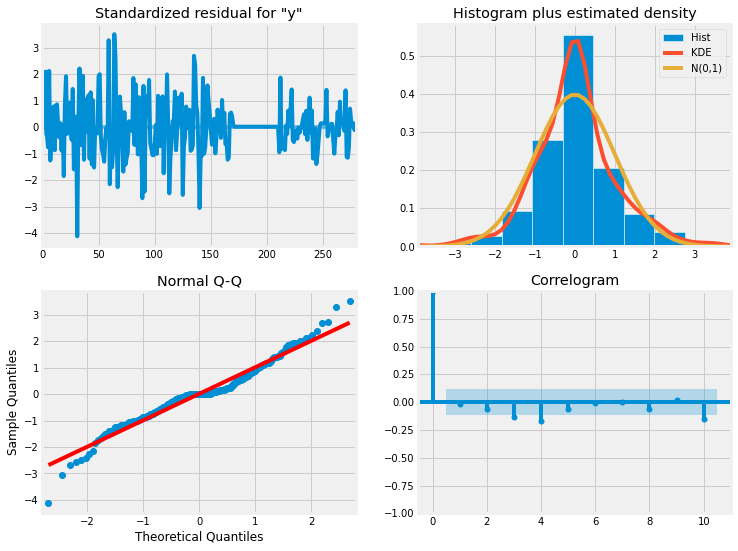

In [51]:
train_sample = time_ser.iloc[1:-50].values

model = sm.tsa.SARIMAX(train_sample,order=(2,1,0),trend=None)
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=1, end=train_sample.shape[0]-1)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:train_sample.shape[0]+1], predicted_result))
print("The root mean squared error is {}.".format(rmse))


In [62]:
# y_hat.shape[0]
train

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5,Train,month,year,day,week,dow,woy,preds,errors,abs_errors
0,ID_JBYXJEUZ8X,2020-03-18,5,0.35346,32.56032,0.846844,22.038542,-0.000138,1.042629,-0.000143,0.291358,76.594910,10.253360,-93.091621,19.181372,-0.000013,0.033740,2457.111816,1353.664673,829636.000000,70.372986,10.312428,-93.008011,19.194933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000121,1.544095,0.000092,0.291358,19.181372,-93.091621,10.253360,76.594910,-1.642264,829649.462314,76.614163,10.023067,-93.106096,19.208093,0.116777,2.088620,0.247530,228.155121,0.410418,76.614163,10.023067,-93.106096,19.208093,0.436799,61535.804688,4181.792969,69589.453125,3181.793457,7.799846,0.278111,76.618553,9.970293,-93.110069,19.214193,63.853333,1,3,2020,18,12,2,12,52.066957,11.786377,11.786377
1,ID_PEJJNLBUPR,2019-10-13,2,0.39074,32.58226,0.874493,21.545833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.217813,829826.625000,-97.723816,58.456985,-103.695694,36.372738,0.117282,3.037993,0.359782,226.432358,0.460678,-97.723816,58.456985,-103.695694,36.372738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.507083,1,10,2019,13,41,6,41,41.801313,-9.294230,9.294230
2,ID_21L8UZQO1T,2019-12-21,0,0.28575,32.57833,0.729340,23.568655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033424,1810.823901,3233.827797,829918.443326,-95.674725,63.742213,-127.837690,40.854694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.691562,829964.437500,-97.300751,63.690495,-127.856827,40.857887,0.109824,3.483419,0.385656,223.476852,0.656354,-97.300751,63.690495,-127.856827,40.857887,0.657462,59516.625000,4440.391113,67341.109375,3440.390869,62.496590,0.416631,-97.300758,63.690605,-127.856

In [63]:
# np.sqrt(((time_ser[1:-1] - np.cumsum(predicted_result))**2).mean())
# mean_absolute_error()
i = 4


11.026495266605496
9.684951176830522


In [55]:
# result.predict(time_ser.index)
# correct[]

array([  8.31052005,   7.49299666,   4.65076751,  20.32699593,
         7.03691922,   9.57423867,   3.8951587 ,  10.02308323,
         3.93480314,  12.6962105 ,  16.48419815,  19.53520294,
        17.80754746,  17.87231368,   9.6042097 ,  11.75910055,
        -6.59186973,   2.70062877,  14.29577816,  15.03546672,
        18.52293206,  23.04642625,  24.79174098,  23.78892124,
        35.44626098,  19.55678757,  28.30491882,  25.85668803,
        -7.28453054,  -2.2486651 ,   4.99310408,  13.53963363,
        13.63197562,  27.6989883 ,  14.29621353,  30.3790529 ,
        23.85397038,  25.75269419,  35.92352863,  23.87101916,
        39.42436341,  22.4416863 ,  36.14911213,  18.32584042,
        22.05524175,  16.43173494,  15.32224735,  32.16036433,
        47.3376633 ,  48.68473775,  44.61786874,  32.7351036 ,
        20.84963388,  16.77769071,  14.44013603,  11.66265211,
        40.39756216,  19.12888254,  27.76713459,   5.95043575,
         1.14758665,  29.51430636,  49.33561966,  57.21

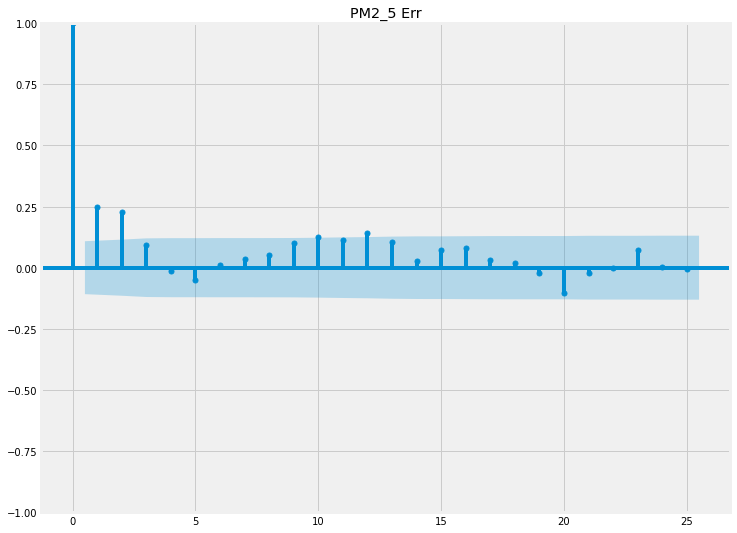

In [29]:
# a = train.site_latitude.unique()
# train.reset_index(drop = True, inplace = True)
plot_acf(time_ser,lags=25,title="PM2_5 Err")
plt.show()

In [35]:
adf = adfuller(time_ser)
print("p-value of pm2_5: {}".format(float(adf[1])))
# adf = adfuller(google["Volume"])
# print("p-value of google: {}".format(float(adf[1])))

p-value of pm2_5: 1.841549343828562e-15


<AxesSubplot:xlabel='date'>

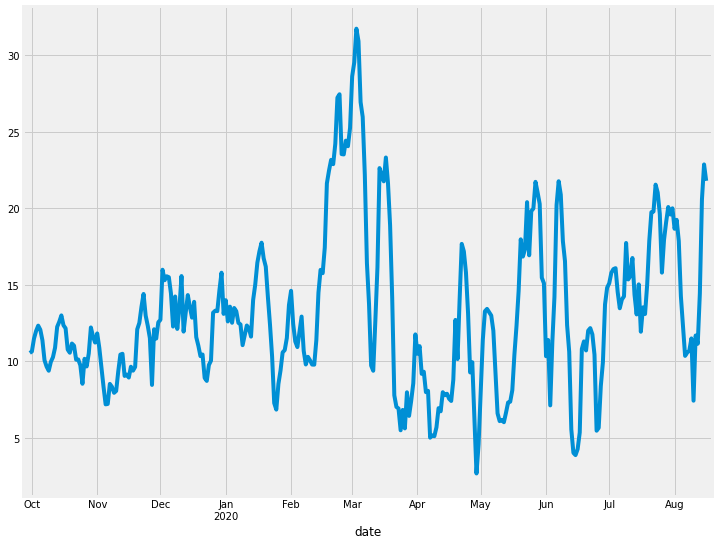

In [36]:
decomposed_google_volume.trend.plot()


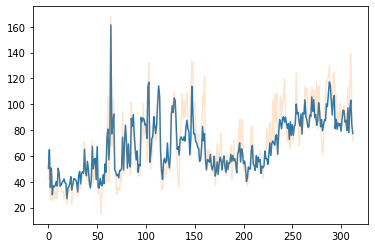

In [17]:
plt.plot(train.groupby('site_latitude').get_group(a[0]).sort_values(by = 'date')['preds'].values)
plt.plot(train.groupby('site_latitude').get_group(a[0]).sort_values(by = 'date')['pm2_5'].values,alpha = 0.2)
# train

In [50]:
# train['errors'] = train['preds'] - train['pm2_5']
(train.date.max()- train.date.min()).days

525

In [125]:
# train.drop(drop_cols2, axis = 1)[abs(train['preds'] - train['pm2_5'])>15].corr()['pm2_5'].sort_values(ascending = False, key = abs)


In [126]:
X_

array([ 0.35346,  0.39074,  0.28575, -1.24498,  0.3564 ,  0.30758,
        0.34373,  0.39148,  0.31545,  0.37956,  0.30667,  0.34701,
        0.38158,  0.0596 ,  0.35799,  0.3075 ,  0.2866 ,  0.31997,
        0.3101 ,  0.3439 ,  0.29875,  0.37308,  0.28368,  0.26501,
        0.30749,  0.36075,  0.28904,  0.2182 ,  0.30778,  0.35482,
        0.344  ,  0.3547 ,  0.3517 ,  0.36021])

In [138]:
# X_train = train.loc[(train.site_laritude == a[0])]
# lr.fit()
def get_train_val(train,test_size,group):
    temp = train.loc[(train.site_latitude == group)]
    X_train = temp.loc[temp.date < temp.date.min() + (1-test_size)*(temp.date.max()-temp.date.min()) ]
    X_val = temp.loc[temp.date >= temp.date.min() + (1-test_size)*(temp.date.max()-temp.date.min())]
    return X_train, X_val

In [140]:
from sklearn.metrics import mean_absolute_error as mae

In [67]:
def fit_line(group,test_size):
    X_train, X_val = get_train_val(train.fillna(0),test_size,group)
    lr = LinearRegression()
    lr.fit(X_train.drop(drop_cols, axis = 1),np.log(X_train['pm2_5']))
    preds = np.exp(lr.predict(X_val.drop(drop_cols, axis = 1)))
    plt.plot(X_val['pm2_5'].values,label = 'True')
    plt.plot(preds,label = 'preds')
    plt.axhline(y = X_train['pm2_5'].mean())
    plt.legend()
    plt.show()
    print(mae(X_val['pm2_5'],preds))

In [68]:
fit_line(group = a[2],test_size = 0.1)


NameError: name 'a' is not defined

In [18]:
def anal(i,preds,y_oof,log = False):
    if log:
        test['pm2_5'] = np.exp(preds)
    else:
        test['pm2_5'] = preds

    all_data = pd.concat([train,test])
    a = all_data.groupby('site_latitude').get_group(all_data.site_latitude.unique()[i])[['date','pm2_5','Train']]
    y1 = a.loc[a.Train == 1].sort_values(by = 'date')['pm2_5'].values
    y2 = a.loc[a.Train == 0].sort_values(by = 'date')['pm2_5'].values
    x1 = range(len(y1))
    x2 = range(len(y1),len(y1)+len(y2))
    if log :
        y3 = np.exp(y_oof[a.loc[a.Train == 1].index])
    else:
        y3 = y_oof[a.loc[a.Train == 1].index]
    plt.plot(x1,y1,label = 'true')
    plt.plot(x1,y3)
    plt.plot(x2,y2)
    

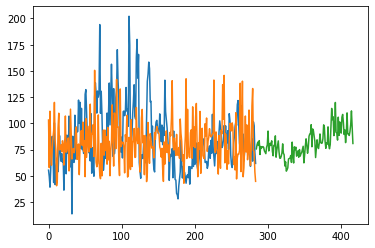

In [23]:
# anal(1,y_predicted_cat)
# anal(7,y_predicted_lgb,y_oof_lgb)
# test.groupby('site_code')

# sns.distplot(test['pm2_5'])

# sns.distplot(train['pm2_5'])
# train.groupby('site_latitude')['site_longitude'].unique()
# train.groupby('site_code').apply(lambda )
# train.index = train.date

,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5,Train,month,year,day,week,dow,woy,rel_date,site_code,preds
0,16.0,-1.24498,29.98924,0.991833,14.058333,-1.675318e-04,1.439262,-2.411221e-04,0.229150,-100.536606,29.266684,-70.037514,27.477388,-1.098045e-04,0.029542,1769.049974,1303.112997,830040.675191,-98.162869,29.224369,-70.002930,27.481755,0.000041,0.000008,0.000033,0.000087,8613.273041,-1.186050,0.146440,830062.0000,-100.536606,29.266684,-70.037514,27.477388,0.000131,2.286472,0.000229,0.229150,27.477388,-70.037514,29.266684,-100.536606,-1.186078,830062.000000,-100.536606,29.266684,-70.037514,27.477388,0.120523,2.282657,0.279412,229.614334,0.234132,-100.536606,29.266684,-70.037514,27.477388,0.234335,68520.523438,3304.507812,77259.148438,2304.507812,10.194275,0.373142,-100.536613,29.266832,-70.037529,27.477406,50.216700,1.0,4.0,2019.0,10.0,15.0,2.0,15.0,318.0,0.0,45.795564
1,16.0,-1.24498,29.98924,0.948075,15.296250,-8.343319e-05,1.159798,-1.202682e-04,0.202037,-13.300415,35.567424,-64.501335,23.438059,-5.477291e-05,0.028245,2147.631921,2548.658183,829861.118845,-13.049147,35.485199,-64.542490,23.455099,0.000043,0.000010,0.000033,0.000092,8613.274881,-1.892071,0.128259,829885.0000,-13.300415,35.567424,-64.501335,23.438059,0.000087,1.756909,0.000102,0.202037,23.438059,-64.501335,35.567424,-13.300415,-1.892084,829885.000000,-13.300415,35.567424,-64.501335,23.438059,0.121540,2.343575,0.290115,227.460030,0.206429,-13.300415,35.567424,-64.501335,23.438059,0.206576,55601.111328,5176.206543,62942.117188,4176.206543,8.364834,0.342693,-13.300426,35.567420,-64.501373,23.438078,89.827710,1.0,4.0,2019.0,11.0,15.0,3.0,15.0,338.0,0.0,41.494419
2,16.0,-1.24498,29.98924,0.904317,16.534167,6.654166e-07,0.880334,5.857885e-07,0.174923,73.935776,41.868164,-58.965157,19.398729,2.587009e-07,0.026948,2526.2138

In [410]:
# df.select_dtypes(exclude ='object')
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
imputer.fit_transform(df.drop('date',axis = 1).values)


array([[ 1.60000000e+01, -1.24498000e+00,  2.99892400e+01, ...,
         1.50000000e+01,  3.18000000e+02,  0.00000000e+00],
       [ 1.48409755e+01,  2.42511714e-01,  3.24720127e+01, ...,
         2.53337700e+01,  2.44951023e+02,  1.55819813e+01],
       [ 1.60000000e+01, -1.24498000e+00,  2.99892400e+01, ...,
         1.50000000e+01,  3.58000000e+02,  0.00000000e+00],
       ...,
       [ 2.90000000e+01,  3.91480000e-01,  3.26258300e+01, ...,
         3.40000000e+01,  4.49000000e+02,  3.40000000e+01],
       [ 2.90000000e+01,  3.91480000e-01,  3.26258300e+01, ...,
         3.40000000e+01,  3.01000000e+02,  3.40000000e+01],
       [ 2.90000000e+01,  3.91480000e-01,  3.26258300e+01, ...,
         3.40000000e+01,  2.00000000e+01,  3.40000000e+01]])

In [388]:
test.index = test.date

In [389]:
test.sort_index().groupby('site_code').resample('D').mean().shape

(4433, 78)

In [390]:
test.shape

(4254, 80)

,ID,pm2_5
0,ID_UOH62J0XHX,30.594022
1,ID_4OPWSB0UHJ,119.928220
2,ID_3SLMNNG1Z3,58.135105
3,ID_MFUHTXYPM4,71.202621
4,ID_TY1DAND8ZP,78.948920
...,...,...
4249,ID_NYKGOYFBKZ,54.976234
4250,ID_IWO4EVLHSQ,79.446282
4251,ID_G1M1IMY9WU,58.147766
4252,ID_DXV65Q1QXI,64.442309


In [48]:
sub

,ID,pm2_5
0,ID_UOH62J0XHX,35.932458
1,ID_4OPWSB0UHJ,115.519109
2,ID_3SLMNNG1Z3,60.979665
3,ID_MFUHTXYPM4,68.402457
4,ID_TY1DAND8ZP,93.404562
...,...,...
4249,ID_NYKGOYFBKZ,55.473415
4250,ID_IWO4EVLHSQ,85.472135
4251,ID_G1M1IMY9WU,62.928728
4252,ID_DXV65Q1QXI,66.639720


In [49]:
sub.to_csv('lgb_5.csv',index = False)

In [60]:
from catboost import Pool, CatBoostRegressor
params_cat = {'iterations':1500,
        'learning_rate':0.01,
        'random_strength':0.1,
        'depth':8,
        'loss_function':'MAE',
        'eval_metric':'MAE',
        'verbose' : 100}
y_predicted_cat,models_cat,y_oof_cat,oof_score_cat =train_catbo(train.drop(drop_cols,axis = 1),
                                                                y,test.drop(drop_cols,axis = 1),params_cat,42,
                                                               True)

fold 1 of 5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 20.6804579	test: 20.2497931	best: 20.2497931 (0)	total: 53.9ms	remaining: 1m 20s
100:	learn: 13.9973480	test: 13.7554360	best: 13.7554360 (100)	total: 3.41s	remaining: 47.3s
200:	learn: 11.5570069	test: 11.6081269	best: 11.6081269 (200)	total: 6.82s	remaining: 44.1s
300:	learn: 10.3208751	test: 10.5304648	best: 10.5304648 (300)	total: 10.1s	remaining: 40.4s
400:	learn: 9.4674735	test: 9.8269943	best: 9.8269943 (400)	total: 13.4s	remaining: 36.9s
500:	learn: 8.7961507	test: 9.2958582	best: 9.2958582 (500)	total: 16.8s	remaining: 33.4s
600:	learn: 8.2715720	test: 8.8973706	best: 8.8973706 (600)	total: 20.4s	remaining: 30.6s
700:	learn: 7.8072021	test: 8.5434350	best: 8.5434350 (700)	total: 23.9s	remaining: 27.2s
800:	learn: 7.4354522	test: 8.2816883	best: 8.2816883 (800)	total: 28s	remaining: 24.5s
900:	learn: 7.1137646	test: 8.0548005	best: 8.0548005 (900)	total: 31.5s	remaining: 21s
1000:	learn: 6.8496607	test: 7.8987368	best: 7.8987368 (1000)	total: 34.9s	remaining: 17.4s
11

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 20.6943234	test: 20.2216891	best: 20.2216891 (0)	total: 54.6ms	remaining: 1m 21s
100:	learn: 14.1080265	test: 13.6979842	best: 13.6979842 (100)	total: 3.68s	remaining: 50.9s
200:	learn: 11.6351672	test: 11.4593645	best: 11.4593645 (200)	total: 7.12s	remaining: 46s
300:	learn: 10.4398678	test: 10.4655341	best: 10.4655341 (300)	total: 10.5s	remaining: 41.8s
400:	learn: 9.5655546	test: 9.8089559	best: 9.8089559 (400)	total: 13.8s	remaining: 37.9s
500:	learn: 8.8903684	test: 9.3050570	best: 9.3050570 (500)	total: 17.2s	remaining: 34.3s
600:	learn: 8.3463844	test: 8.9023089	best: 8.9023089 (600)	total: 20.6s	remaining: 30.8s
700:	learn: 7.8725927	test: 8.5484806	best: 8.5484806 (700)	total: 23.9s	remaining: 27.3s
800:	learn: 7.4946690	test: 8.2783577	best: 8.2783577 (800)	total: 27.7s	remaining: 24.2s
900:	learn: 7.1727709	test: 8.0781945	best: 8.0781945 (900)	total: 31.2s	remaining: 20.7s
1000:	learn: 6.8766398	test: 7.9013005	best: 7.9013005 (1000)	total: 34.9s	remaining: 17.4s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 20.6022263	test: 20.5568725	best: 20.5568725 (0)	total: 53.8ms	remaining: 1m 20s
100:	learn: 13.8699374	test: 13.9449894	best: 13.9449894 (100)	total: 3.68s	remaining: 51s
200:	learn: 11.4437029	test: 11.8393031	best: 11.8393031 (200)	total: 7.02s	remaining: 45.4s
300:	learn: 10.2074288	test: 10.7972189	best: 10.7972189 (300)	total: 10.4s	remaining: 41.4s
400:	learn: 9.3568074	test: 10.1275683	best: 10.1275683 (400)	total: 14.1s	remaining: 38.6s
500:	learn: 8.7161984	test: 9.6324848	best: 9.6324848 (500)	total: 17.4s	remaining: 34.6s
600:	learn: 8.2072002	test: 9.2702798	best: 9.2702798 (600)	total: 20.7s	remaining: 31s
700:	learn: 7.7739017	test: 8.9682680	best: 8.9682680 (700)	total: 24.1s	remaining: 27.5s
800:	learn: 7.4044723	test: 8.7111698	best: 8.7111698 (800)	total: 27.4s	remaining: 23.9s
900:	learn: 7.0967443	test: 8.5202318	best: 8.5202318 (900)	total: 30.8s	remaining: 20.5s
1000:	learn: 6.8346659	test: 8.3640678	best: 8.3640678 (1000)	total: 34.8s	remaining: 17.4s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 20.6126207	test: 20.5124201	best: 20.5124201 (0)	total: 52.1ms	remaining: 1m 18s
100:	learn: 13.9168300	test: 14.4653887	best: 14.4653887 (100)	total: 3.38s	remaining: 46.8s
200:	learn: 11.5004732	test: 12.3066641	best: 12.3066641 (200)	total: 6.71s	remaining: 43.3s
300:	learn: 10.2652195	test: 11.1813590	best: 11.1813590 (300)	total: 10s	remaining: 39.9s
400:	learn: 9.4536080	test: 10.4616411	best: 10.4616411 (400)	total: 13.4s	remaining: 36.6s
500:	learn: 8.8134786	test: 9.9142701	best: 9.9142701 (500)	total: 16.7s	remaining: 33.3s
600:	learn: 8.2952283	test: 9.4934253	best: 9.4934253 (600)	total: 20s	remaining: 29.9s
700:	learn: 7.8539801	test: 9.1634367	best: 9.1634367 (700)	total: 24.1s	remaining: 27.4s
800:	learn: 7.4879989	test: 8.8795040	best: 8.8795040 (800)	total: 27.4s	remaining: 23.9s
900:	learn: 7.1503085	test: 8.6423372	best: 8.6423372 (900)	total: 30.8s	remaining: 20.4s
1000:	learn: 6.8716627	test: 8.4654100	best: 8.4654100 (1000)	total: 34.1s	remaining: 17s
11

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 20.3857817	test: 21.4519407	best: 21.4519407 (0)	total: 55.5ms	remaining: 1m 23s
100:	learn: 13.7530353	test: 15.0019131	best: 15.0019131 (100)	total: 3.78s	remaining: 52.4s
200:	learn: 11.3516368	test: 12.8038341	best: 12.8038341 (200)	total: 7.09s	remaining: 45.8s
300:	learn: 10.0630382	test: 11.6527315	best: 11.6527315 (300)	total: 10.4s	remaining: 41.4s
400:	learn: 9.2910583	test: 10.9796413	best: 10.9796413 (400)	total: 13.8s	remaining: 37.7s
500:	learn: 8.6264632	test: 10.4434483	best: 10.4434483 (500)	total: 17.1s	remaining: 34.1s
600:	learn: 8.0618670	test: 9.9956663	best: 9.9956663 (600)	total: 20.5s	remaining: 30.6s
700:	learn: 7.6273096	test: 9.6697939	best: 9.6697939 (700)	total: 23.9s	remaining: 27.2s
800:	learn: 7.2734446	test: 9.4375479	best: 9.4375479 (800)	total: 27.2s	remaining: 23.8s
900:	learn: 6.9482909	test: 9.2128718	best: 9.2128718 (900)	total: 30.6s	remaining: 20.3s
1000:	learn: 6.6709924	test: 9.0235139	best: 9.0235139 (1000)	total: 34.3s	remaining: 